# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Теперь настало время самостоятельной работы. В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка. 

> **Примечание.** Вы уже знакомились с этой задачей в модуле по визуализации («PYTHON-13. Визуализация данных») и провели небольшое исследование данных. Вы можете использовать результаты своего исследования для построения модели машинного обучения.

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов. 

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


Для начала импортируем библиотеки, которые нам понадобятся:

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
%matplotlib inline

Итак, прочитаем нашу таблицу:

In [2]:
churn_data = pd.read_csv('data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Практика: логистическая регрессия

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9:

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

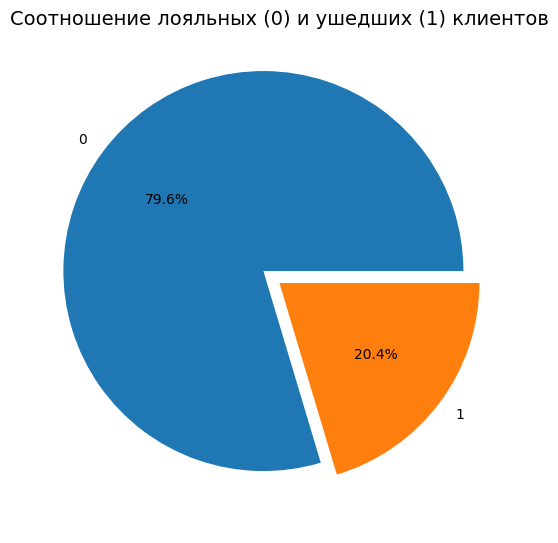

In [3]:
# Соотношение лояльных и ушедших клиентов
ratio_clients = churn_data['Exited'].value_counts()
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.set_title('Соотношение лояльных (0) и ушедших (1) клиентов', fontsize=14)
axes.pie(
    ratio_clients,
    labels=ratio_clients.index,
    autopct='%.1f%%',
    explode = [0.1, 0]
);

Процент лояльных клиентов составляет 79,6%, процент ушедших клиентов составляет 20,4%.

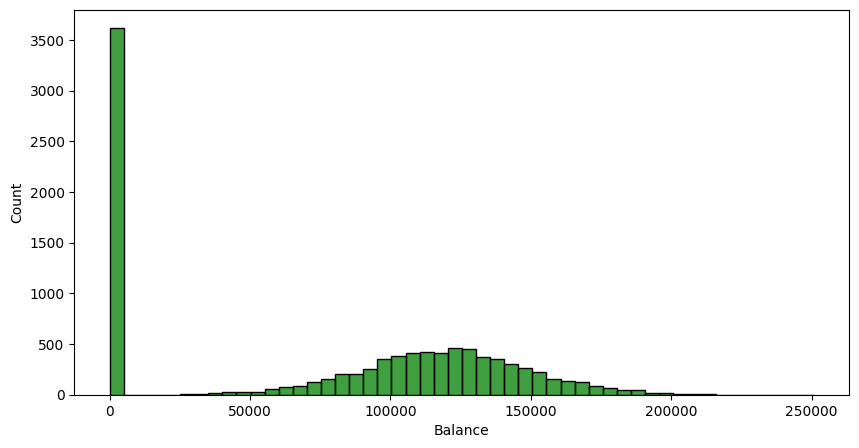

In [4]:
# График распределения баланса клиентов.
fig = plt.figure(figsize=(10, 5))
sns.histplot(
    data=churn_data,
    x='Balance',
    bins=50,
    color='green'
);


Видно, что много клиентов, которые имеют нулевой баланс. Посмотрим на распределение без этих клиентов

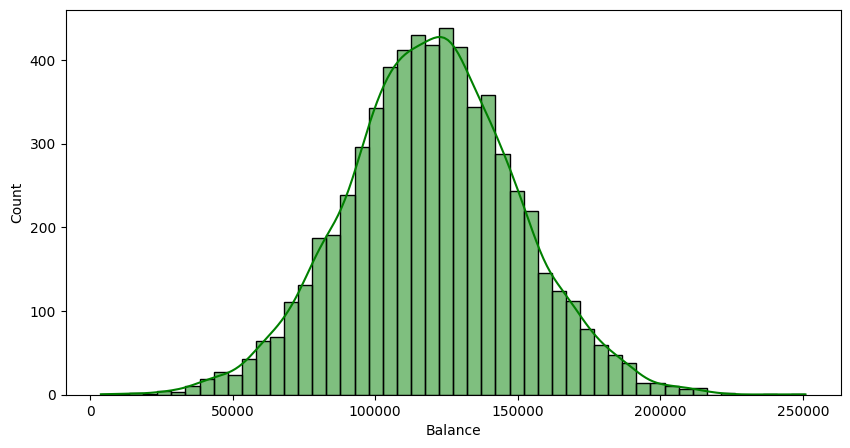

In [5]:
# График распределения баланса клиентов у которых имеются средства на балансе.
fig = plt.figure(figsize=(10, 5))
client_balances = churn_data[churn_data['Balance'] > 0]
sns.histplot(
    data=client_balances,
    x='Balance',
    bins=50,
    kde=True,
    color='green'
);

Данный график имеет нормальное распределение. Диапазон баланса составляет от 1 до 250000 долларов. Наибольшее число клиентов имеет баланс около 120000 долларов.

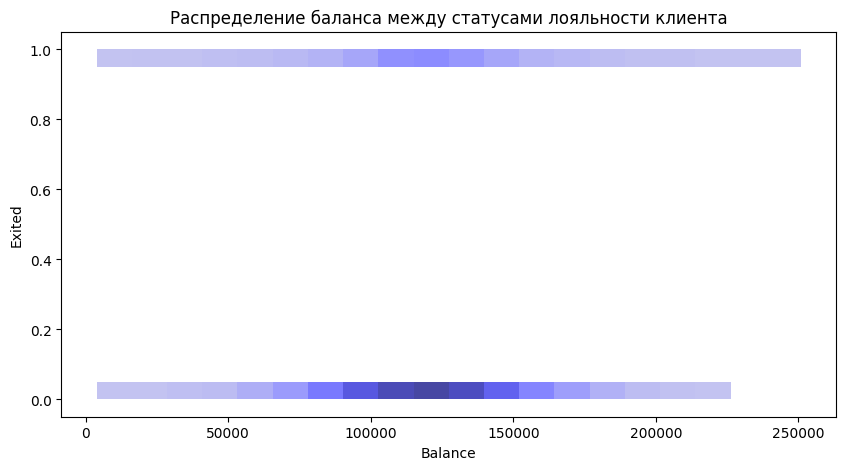

In [6]:
# Распределение баланса между статусами лояльности клиента
fig = plt.figure(figsize=(10, 5))
client_balances = churn_data[churn_data['Balance'] > 0]

client = sns.histplot(
    data=client_balances,
    x='Balance',
    y='Exited',
    bins=20,
    color='blue'
)
client.set_title('Распределение баланса между статусами лояльности клиента', fontsize=12);

В разрезе признака оттока можно видеть, что суммы у лояльных клиентов на счету гораздо больше, чем у ушедших. Основная масса лояльных клиентов имеет на счете сумму около 120000$, тогда как у ушедших клиентов баланс равномерно размазан в широком диапазоне. Более большие суммы у лояльных клиентов может говорить о том, что эти клиенты активно пользуются услугами банка - берут кредиты, хранят свои сбережения и выполняют расчеты в этом банке. Еще это может быть связано с долгосрочными вкладами или активами, которые клиенты держат в этом банке. Им будет невыгодно уходить в другой банк, так как в этом банке у них хороший рейтинг и им дают кредит под меньший процент. На долю ушедших клиентов приходится значительно меньше капиталла. Этим клиентам нет необходимости оставаться в этом банке, так как их суммы незначительны по сравнению с лояльными клиентами.

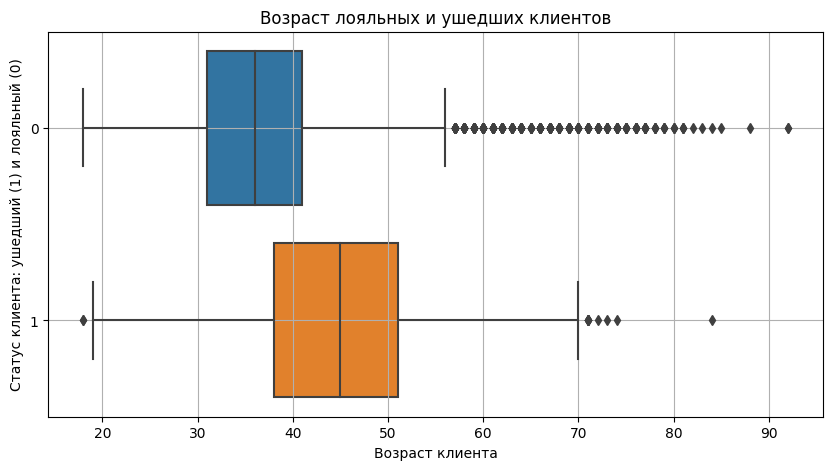

In [7]:
# Распределение возраста в разрезе признака оттока.
fig = plt.figure(figsize=(10, 5))
boxplot = sns.boxplot(
    data=churn_data,
    y='Exited',
    x='Age',
    orient='h',
)
boxplot.set_title('Возраст лояльных и ушедших клиентов', fontsize=12);
boxplot.set_xlabel('Возраст клиента');
boxplot.set_ylabel('Статус клиента: ушедший (1) и лояльный (0)');
boxplot.grid()

Вывод. Число потенциальных выбросов больше у лояльных клиентов. Выглядит нелогично, когда верхняя граница возраста лояльных клиентов значительно ниже ушедших, так как лояльность означает, что клиент продолжает пользоваться услугами банка. Лояльные клиенты в возрасте 56 и более лет нуждаются в дополнительном исследовании из-за большого числа выбросов. Возможно удасться выявить причину таких частых выбросов и повысить прогноз оттока.

Text(0, 0.5, 'Прелпологаемая заработная плата')

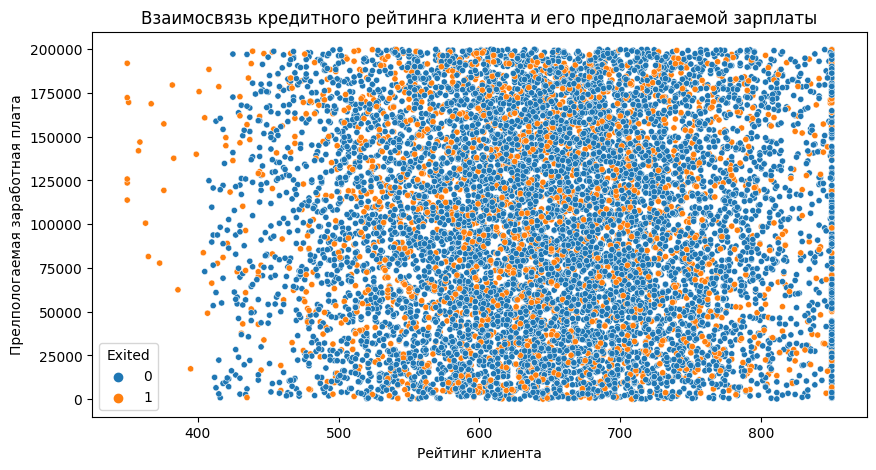

In [8]:
# Взаимосвязь кредитного рейтинга клиента и его предполагаемой зарплаты.
fig = plt.figure(figsize=(10, 5))
relationship = sns.scatterplot(
    data=churn_data,
    x='CreditScore',
    y='EstimatedSalary',
    hue='Exited',
    s=20,
)
relationship.set_title('Взаимосвязь кредитного рейтинга клиента и его предполагаемой зарплаты', fontsize=12)
relationship.set_xlabel('Рейтинг клиента')
relationship.set_ylabel('Прелпологаемая заработная плата')

Рейтинг и предпологаемая зарплата не взаимосвязаны между собой и не зависят от типа клиента.

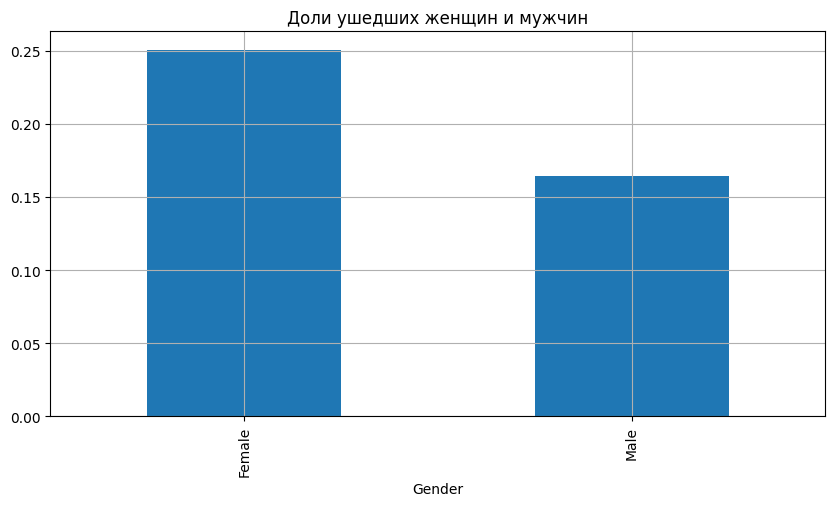

In [9]:
# Соотношение мужчин или женщин, которые прекратили пользоваться услугами банка.
grouped_genders = churn_data.groupby(['Gender'])['Exited'].mean()
grouped_genders.plot(
    kind='bar',
    grid=True,
    figsize=(10, 5),
    title='Доли ушедших женщин и мужчин'
);

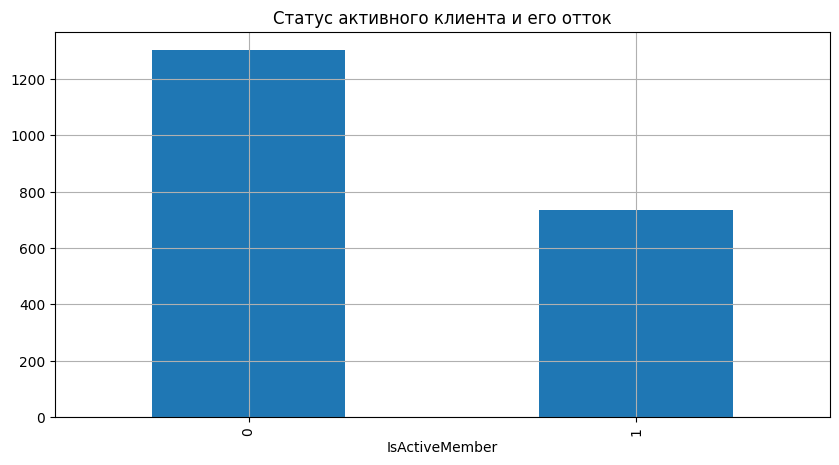

In [10]:
#  Влияние наличия статуса активного клиента на отток.
customer_activity = churn_data.groupby(['IsActiveMember'])['Exited'].sum()
customer_activity.plot(
    kind='bar',
    grid=True,
    title='Статус активного клиента и его отток',
    figsize=(10, 5)
);

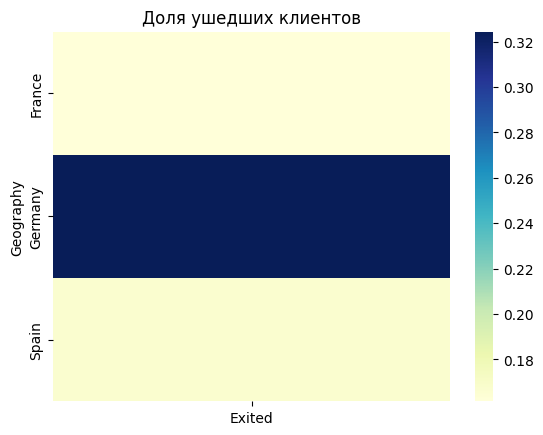

In [11]:
# Доля ушедших клиентов по странам.
pivot = churn_data.pivot_table(
    values='Exited',
    #columns='IsActiveMember',
    index='Geography',
    aggfunc='mean'
)
heatmap = sns.heatmap(data=pivot, cmap='YlGnBu');
heatmap.set_title('Доля ушедших клиентов');

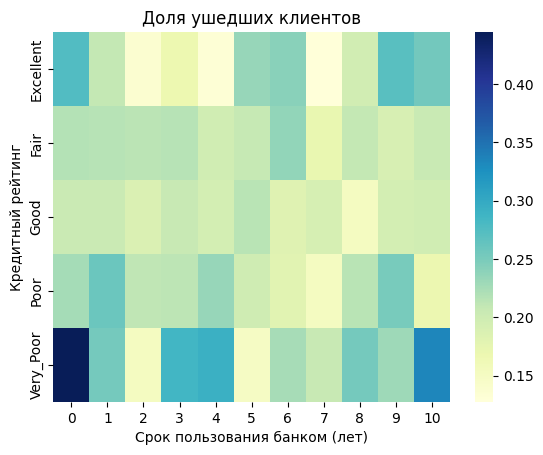

In [12]:
# Зависимость кредитного рейтинга от срока пользования услугами банка.
def get_credit_score_cat(credit_score):
    if credit_score >= 300 and credit_score < 500:
        return "Very_Poor"
    elif credit_score >= 500 and credit_score < 601:
        return "Poor"
    elif credit_score >= 601 and credit_score < 661:
        return "Fair"
    elif credit_score >= 661 and credit_score < 781:
        return "Good"
    elif credit_score >= 781 and credit_score < 851:
        return "Excellent"
    elif credit_score >= 851:
        return "Top"
    elif credit_score < 300:
        return "Deep"

churn_data['CreditScoreCat'] = churn_data['CreditScore'].apply(get_credit_score_cat)

heat_map = churn_data.groupby(['CreditScoreCat', 'Tenure'])['Exited'].mean().unstack()
heatmap2 = sns.heatmap(data=heat_map, cmap='YlGnBu')
heatmap2.set_title('Доля ушедших клиентов');
heatmap2.set_xlabel('Срок пользования банком (лет)');
heatmap2.set_ylabel('Кредитный рейтинг');

По тепловой карте можно сделать вывод, что чаще всего уходят клиенты, которые пользуются услугами банка не более одного года и имеют самый низкий рейтинг. Также можно заметить, что в целом чаще уходят клиенты с малым рейтингом.

В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [13]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 15)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [14]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditScoreCat
7,376,Female,29,4,115046.74,4,1,0,119346.88,1,Very_Poor
15,616,Male,45,3,143129.41,2,0,1,64327.26,0,Fair
16,653,Male,58,1,132602.88,1,1,0,5097.67,1,Fair
26,756,Male,36,2,136815.64,1,1,1,170041.95,0,Good
28,574,Female,43,3,141349.43,1,1,1,100187.43,0,Poor


Проверим, что в наших данных нет пропусков:

In [15]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
CreditScoreCat     0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [16]:
churn_data[churn_data.duplicated()].sum()

CreditScore        0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
CreditScoreCat     0.0
dtype: float64

### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [17]:
# Отношение баланса на счетах к заработной плате клиента
churn_data['BalanceSalaryRatio'] = churn_data['Balance'] / churn_data['EstimatedSalary']

# Отношение времени пользования услугами банка к возрасту клиента;
churn_data['TenureByAge'] = churn_data['Tenure'] / churn_data['Age']

# Отношение кредитного рейтинга к возрасту клиента.
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore'] / churn_data['Age']

import category_encoders as ce # импорт для работы с кодировщиком.

# Кодируем признак Gender.
bin_encoder = ce.BinaryEncoder(cols=['Gender'])
type_bin = bin_encoder.fit_transform(churn_data['Gender'])
churn_data = pd.concat([churn_data, type_bin], axis=1)

# Кодируем признак CreditScoreCat.
bin_encoder = ce.BinaryEncoder(cols=['CreditScoreCat'])
type_bin = bin_encoder.fit_transform(churn_data['CreditScoreCat'])
churn_data = pd.concat([churn_data, type_bin], axis=1)

# Удаляем строковые признаки.
churn_data = churn_data.drop(['Gender', 'CreditScoreCat'], axis=1)

# Основные статистические характеристики признаков.
churn_data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Gender_0,Gender_1,CreditScoreCat_0,CreditScoreCat_1,CreditScoreCat_2
count,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.00000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000
mean,651.453567,39.771622,5.009964,119730.116134,1.519729,0.71383,0.497409,101113.435102,0.324432,9.024870,0.134303,17.526487,0.524512,0.475488,0.335592,0.595855,0.529693
std,98.168937,10.519143,2.935154,27022.006157,0.619420,0.45206,0.500093,58263.011501,0.468256,214.286020,0.087680,5.349558,0.499498,0.499498,0.472291,0.490824,0.499217
min,350.000000,18.000000,0.000000,27288.430000,1.000000,0.00000,0.000000,11.580000,0.000000,0.192582,0.000000,6.112676,0.000000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,32.000000,2.000000,102800.720000,1.000000,0.00000,0.000000,51016.020000,0.000000,0.783284,0.060606,13.686275,0.000000,0.000000,0.000000,0.000000,0.000000
50%,651.000000,38.000000,5.000000,119703.100000,1.000000,1.00000,0.000000,102397.220000,0.000000,1.197220,0.125000,16.857143,1.000000,0.000000,0.000000,1.000000,1.000000
75%,722.000000,45.000000,8.000000,137560.380000,2.000000,1.00000,1.000000,151083.800000,1.000000,2.400083,0.200000,20.852941,1.000000,1.000000,1.000000,1.000000,1.000000
max,850.000000,84.000000,10.000000,214346.960000,4.000000,1.00000,1.000000,199970.740000,1.000000,10614.655440,0.500000,46.388889,1.000000,1.000000,1.000000,1.000000,1.000000


Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [18]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [19]:
y.value_counts(normalize=True)

0    0.675568
1    0.324432
Name: Exited, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [20]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 16)
Test shape: (628, 16)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [21]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


0    0.675704
1    0.324296
Name: Exited, dtype: float64



Test :


0    0.675159
1    0.324841
Name: Exited, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [22]:
# Инициализируем нормализатор StandardScaler
scaler = preprocessing.StandardScaler()
# Обучение.
scaler.fit(X_train)

# Трансформация тренировочных и тестовых данных (признаков).
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор. 


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * выбрана верная метрика;
    * приведено развернутое обоснование выбора метрики, и приведенные рассуждения являются верными;

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

### Выбор метрики
Для минимизации количества звонков подойдет метрика Precision, которая говорит о точности предсказания. Для охвата больщего числа клиентов необходимо применить метрику Recall. Но так как ресурсы ограничены, но при этом хотелось бы охватить как можно большее количество клиентов, то больше подходит комбинация этих метрик - то есть метрика F1. Данная метрика позволяет минимизировать как ложноположительные так и ложноотрицательные срабатывания модели в зависимости от выбранной доли значимости каждой из метрик Precision и Recall.

### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [23]:
# Создаём объект класса LogisticRegression
log_reg = linear_model.LogisticRegression(C=0.5, random_state=42) # L1-регуляризация приводит к ошибке. Поэтому оставил L2 по-умолчанию.

# Обучаем модель.
log_reg.fit(X_train_scaled, y_train)

# Делаем предсказания для тренировочной и тестовой выборок.
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

# Вывод метрики F1 для тренировочной выборки.
print('Train: {:.3f}'.format(metrics.f1_score(y_train, y_train_pred)))

# Вывод метрики F1 для тестовой выборки.
print('Test: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.514
Test: 0.504


### Вывод
Путем дополнительного подбора параметра С=0.5 удалось добиться максимальных, на данном этапе, метрик F1. Так как метрика примерно равна у тренировочной и тестовой выборок, то можно сделать вывод, что модель не переобучена. Однако полученная модель является слабо обученной и малопригодна для применения (тем более в банковском деле), так как метрика невысокая.

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [24]:
# Создаём генератор полиномиальных признаков
churn_poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
churn_poly.fit(X_train_scaled)

# Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = churn_poly.transform(X_train_scaled)
# Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = churn_poly.transform(X_test_scaled)

# Создаём объект класса LogisticRegression
log_reg_2 = linear_model.LogisticRegression(penalty='l2', C=0.005, random_state=42) # L1-регуляризация приводит к ошибке. Поэтому оставил L2 по-умолчанию.
# Обучаем модель на полиномиальных признаках.
log_reg_2.fit(X_train_poly, y_train)

# Делаем предсказания для тренировочной и тестовой выборок (метки классов).
y_train_pred_poly = log_reg_2.predict(X_train_poly)
y_test_pred_poly = log_reg_2.predict(X_test_poly)

# Рассчитываем коэффициент F1 для двух выборок с полиномиальными признаками..
print("Train F1: {:.3f}".format(metrics.f1_score(y_train, y_train_pred_poly)))
print("Test F1: {:.3f}".format(metrics.f1_score(y_test, y_test_pred_poly)))

Train F1: 0.741
Test F1: 0.625


### Вывод
После обучения модели на полиномиальных признаках метрика F1 значительно улучшилась. Путем настройки параметров регрессии LogisticRegression удалось поднять метрику как на тренировочных данных, так и на тестовых. Метрика F1 выше на тренировочных данных, что говорит о переобучении модели, но все-таки на тестовой выборке с полиномиальными признаками эта метрика выше чем до этого. Поэтому оставляем новую модель с полиномиальными признаками.

### Задание 5.6. (2 балла)


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

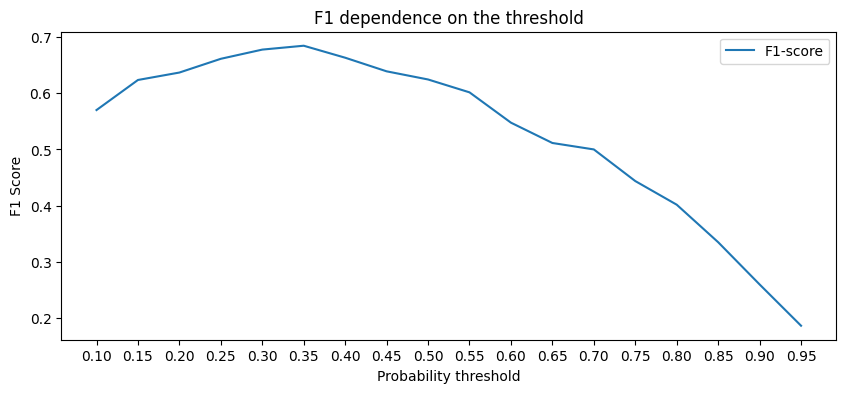

In [25]:
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(log_reg_2.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять значения метрики.
f1_scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание.
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику и добавляем результат в список.
    f1_scores.append(metrics.f1_score(y_test, y_test_pred_poly))

# Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4))
# Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
# Даём графику название и подписываем оси.
ax.set_title('F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('F1 Score')
# Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
# Легенда.
ax.legend();

In [26]:
# На графике видно, что метрика F1 имеет максимальное значение при пороге вероятности 0.35.
# Зададим данный порог как оптимальный и подсчитаем оптимальную метрику F1 для данной модели. 
threshold_opt = 0.35
y_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)

# Оптимальная метрика F1.
print("F1-test: {:.3f}".format(metrics.f1_score(y_test, y_pred_opt)))

F1-test: 0.685


### Вывод
Путем перебора значений порога вероятности был построен график, по которому найдено его оптимальное значение. После этого была проверена метрика качества F1 модели при данном пороге, значение которой равно 0.685, что является хорошим показателем.

## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [27]:
trees_data = pd.read_csv('data/churn.csv')

# Данные, относящиеся только к отделениям банков в Германии.
trees_data = trees_data[trees_data['Geography'] == 'Germany']

# Избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.
trees_data = trees_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)

# Далее создаем новые признаки.
# Отношение баланса на счетах к заработной плате клиента
trees_data['BalanceSalaryRatio'] = trees_data['Balance'] / trees_data['EstimatedSalary']

# Отношение времени пользования услугами банка к возрасту клиента;
trees_data['TenureByAge'] = trees_data['Tenure'] / trees_data['Age']

# Отношение кредитного рейтинга к возрасту клиента.
trees_data['CreditScoreGivenAge'] = trees_data['CreditScore'] / trees_data['Age']

# Категоризация признака 'Gender'.
trees_data['Gender'] = trees_data['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

# Выводим получившийся датасет.
trees_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
7,376,0,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517
15,616,1,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889
16,653,1,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621
26,756,1,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000
28,574,0,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837


In [28]:
# Разделяем исходный набор данных.
X = trees_data.drop("Exited", axis=1)
y = trees_data["Exited"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y,
    stratify=y,
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Импортируем необходимые для выполнения практики модули:

In [29]:
from sklearn import tree
from sklearn import ensemble

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [30]:
# Создаем объект класса дерево решений
trees_data = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
# Обучаем дерево по алгоритму CART
trees_data.fit(X_train, y_train)

# Выводим значения метрики 
y_train_pred = trees_data.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = trees_data.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.57


### Вывод
Модель максимально точно предсказывает тренировочную выборку и плохо тестовую. То есть модель идеально подстроилась под тренировочные данные. Это явный признак переобучения модели.

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [31]:
# Создаем объект класса дерево решений
trees_data = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=8,
    min_samples_leaf=10,
    random_state=42
)
# Обучаем дерево по алгоритму CART
trees_data.fit(X_train, y_train)

# Выводим значения метрики 
y_train_pred = trees_data.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = trees_data.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.72
Test: 0.64


### Вывод
Путем ограничения глубины дерева и объектов в листе удалось улучшить прежние предсказания модели. Данная модель не имеет возможности обучаться до предельно возможной глубины, а следовательно ее переобучение снизилось, что и показывает значение 0.72 на тренировочной выборке.

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [32]:
# Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=500,
    max_depth=8,
    criterion='entropy',
    min_samples_leaf=10,
    random_state=42
)
# Обучаем модель
rf.fit(X_train, y_train)

# Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.74
Test: 0.66


### Вывод
Улучшение метрик при помощи случайного леса почти незаметны. Переобучение увеличилось незначительно и так же незначительно увеличилась метрика предсказания на тестовой выборке.

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

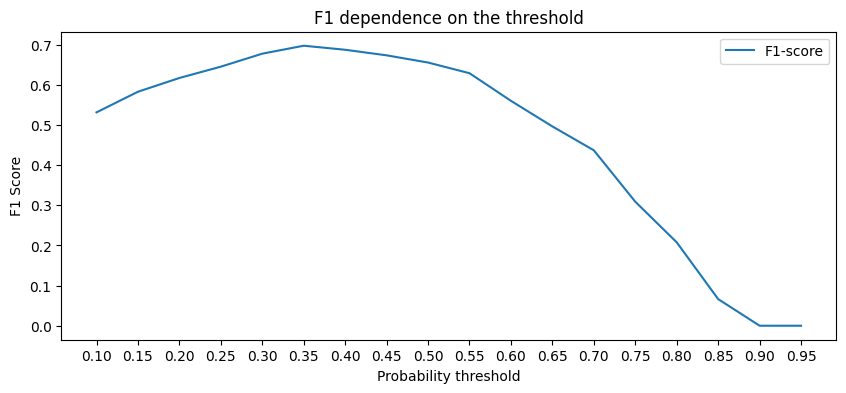

In [33]:
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(rf.predict_proba(X_test)[:, 1])
# Инициализируем список, куда будем сохранять значения метрики.
f1_scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание.
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику и добавляем результат в список.
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

# Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4))
# Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
# Даём графику название и подписываем оси.
ax.set_title('F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('F1 Score')
# Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
# Легенда.
ax.legend();

In [34]:
# На графике видно, что метрика F1 имеет максимальное значение при пороге вероятности 0.35, так же как 
# Зададим данный порог как оптимальный и подсчитаем оптимальную метрику F1 для данной модели. 
threshold_opt = 0.35
y_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)

# Оптимальная метрика F1 при использовании случайного леса.
print("F1-test: {:.3f}".format(metrics.f1_score(y_test, y_pred_opt)))

F1-test: 0.698


### Вывод
После преобразования изначальных данных было произведено обучение модели при помощи логистической регрессии. Путем сравнения изначальных признаков и полиномиальных в логистической регрессии и подбора порога вероятности была получена наилучшая метрика F1, равная 0.685, что является хорошим показателем. После этого была разработана модель при помощи деревьев решений. Полученная модель немного превосходит по выбранной метрике прежнюю модель на основе логистической регрессии и равна 0.698.

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [35]:
# Из всех полученных моделей наилучшей является модель случайного леса. Для применения этой модели данные Василия преобразуем теми же способами, что и при создании DataFrame для ее обучения.

# Преобразуем данные в DataFrame.
vasiliy = pd.DataFrame({
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
})

# Отношение баланса на счетах к заработной плате клиента
vasiliy['BalanceSalaryRatio'] = vasiliy['Balance'] / vasiliy['EstimatedSalary']

# Отношение времени пользования услугами банка к возрасту клиента;
vasiliy['TenureByAge'] = vasiliy['Tenure'] / vasiliy['Age']

# Отношение кредитного рейтинга к возрасту клиента.
vasiliy['CreditScoreGivenAge'] = vasiliy['CreditScore'] / vasiliy['Age']

# Категоризация признака 'Gender'.
vasiliy['Gender'] = vasiliy['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

# Делаем предсказание.
exited = (rf.predict_proba(vasiliy))[0, 0]
print('Вероятность того, что Василий откажется от услуг банка равна {:.3f}'.format(exited))

Вероятность того, что Василий откажется от услуг банка равна 0.386
